**Import packages**

In [1]:
!pip install pytictoc

In [2]:
import random
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [3]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

**Create helper functions**

In [4]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X)
    classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Plot sample image**

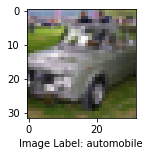

In [5]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index])

**Normalize the input data**

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B

**Load the saved models**

In [8]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_CIFAR10 = load_model('Linear_CIFAR10.h5')
MLP_CIFAR10 = load_model('MLP_CIFAR10.h5')
CNN_CIFAR10 = load_model('CNN_CIFAR10.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


In [9]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\GNA

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\GNA


# Gaussian noise attack (GNA)

**Evaluate test accuracy on unperturbed data**

In [10]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
print()

Test accuracy on unperturbed data
32/32 [==============================] - 3s 74ms/step - loss: 0.3464 - accuracy: 0.8880



**Evaluate test accuracy on perturbed data**

In [12]:
sigmas = np.arange(0,1.1,0.1)
avg_l2_norm_values = np.empty((0,1))
stored_results = []
for i in sigmas:
  stored_results.append(i)
  noise = np.random.normal(size=X_test[indexes].shape, loc=0.0, scale=i)
  X_test_noisy = X_test[indexes] + noise
  X_test_noisy = np.clip(X_test_noisy, 0, 1)
    
  filename = 'CIFAR10_X_test_noisy_GNA_sigma' + str(np.round(i,1)) + '.npy'
  np.save(filename, X_test_noisy)
  
  avg_l2_norm = np.mean(np.sqrt(np.sum((X_test_noisy-X_test[indexes])**2, axis=(1,2,3))))
  stored_results.append(avg_l2_norm)
  print("Average l2 distance of the perturbation:", avg_l2_norm)

  print('\nTest accuracy on perturbed data')
  _,Linear_CIFAR10_test_accuray = Linear_CIFAR10.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(Linear_CIFAR10_test_accuray)

  _,MLP_CIFAR10_test_accuray = MLP_CIFAR10.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(MLP_CIFAR10_test_accuray)

  _,CNN_CIFAR10_test_accuray = CNN_CIFAR10.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(CNN_CIFAR10_test_accuray)

  print('\n')

Average l2 distance of the perturbation: 0.0

Test accuracy on perturbed data
32/32 [==============================] - 2s 72ms/step - loss: 0.3464 - accuracy: 0.8880


Average l2 distance of the perturbation: 5.342810507523255

Test accuracy on perturbed data
32/32 [==============================] - 2s 74ms/step - loss: 4.1989 - accuracy: 0.1650


Average l2 distance of the perturbation: 10.099777876518854

Test accuracy on perturbed data
32/32 [==============================] - 2s 76ms/step - loss: 4.1456 - accuracy: 0.1080


Average l2 distance of the perturbation: 14.035274273880479

Test accuracy on perturbed data
32/32 [==============================] - 2s 74ms/step - loss: 3.7939 - accuracy: 0.1090


Average l2 distance of the perturbation: 17.075173699707396

Test accuracy on perturbed data
32/32 [==============================] - 2s 74ms/step - loss: 3.5280 - accuracy: 0.1220


Average l2 distance of the perturbation: 19.38327585790626

Test accuracy on perturbed data
32/32 [==

In [13]:
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,5)
df = pd.DataFrame(stored_results, columns = ['sigma','avg_l2_norm','Linear_CIFAR10_test_accuray',\
                                 'MLP_CIFAR10_test_accuray','CNN_CIFAR10_test_accuray'])
df.to_csv('Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv', index=False)
df

,sigma,avg_l2_norm,Linear_CIFAR10_test_accuray,MLP_CIFAR10_test_accuray,CNN_CIFAR10_test_accuray
0,0.0,0.000000,0.396,0.493,0.888
1,0.1,5.342811,0.399,0.491,0.165
2,0.2,10.099778,0.359,0.465,0.108
3,0.3,14.035274,0.341,0.434,0.109
4,0.4,17.075174,0.278,0.421,0.122
5,0.5,19.383276,0.246,0.379,0.107
6,0.6,21.108905,0.251,0.342,0.114
7,0.7,22.427679,0.208,0.295,0.112
8,0.8,23.459937,0.220,0.275,0.098
9,0.9,24.284540,0.199,0.254,0.105


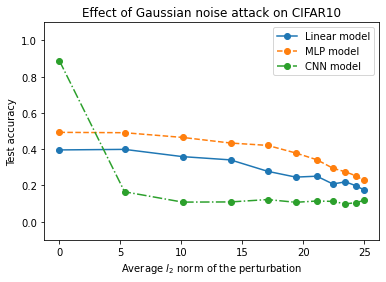

In [14]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv')
plt.plot(df['avg_l2_norm'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['avg_l2_norm'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of Gaussian noise attack on CIFAR10')
plt.savefig('Effect of Gaussian noise attack on CIFAR10 [l2 norm]', dpi=600)
plt.show()

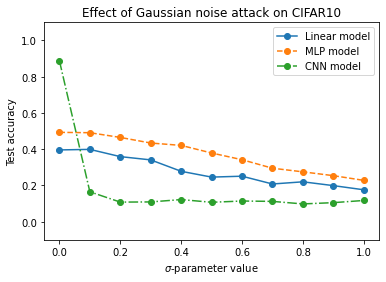

In [11]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 [Gaussian Noise Attack].csv')
plt.plot(df['sigma'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['sigma'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['sigma'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('$\sigma$-parameter value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of Gaussian noise attack on CIFAR10')
plt.savefig('Effect of Gaussian noise attack on CIFAR10 [sigma]', dpi=600)
plt.show()

**Visualize the effect of the added noise**

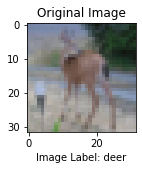

1/1 [==============================] - 0s 69ms/step


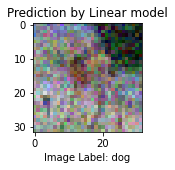

1/1 [==============================] - 0s 147ms/step


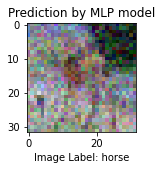

1/1 [==============================] - 0s 387ms/step


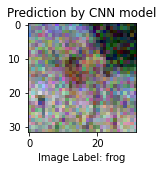

In [16]:
index = 100
plot_sample_image(X_test[index], y_test[index])
plt.title('Original Image'); plt.show()

noise = np.random.normal(size=X_test.shape, loc=0.0, scale=0.1) # Tune scale here
X_test_noisy = X_test + noise
X_test_noisy = np.clip(X_test_noisy, 0, 1)

plot_sample_image(X_test_noisy[index], np.argmax(Linear_CIFAR10.predict(X_test_noisy[index][np.newaxis, ...])))
plt.title('Prediction by Linear model'); plt.show()
plot_sample_image(X_test_noisy[index], np.argmax(MLP_CIFAR10.predict(X_test_noisy[index][np.newaxis, ...])))
plt.title('Prediction by MLP model'); plt.show()
plot_sample_image(X_test_noisy[index], np.argmax(CNN_CIFAR10.predict(X_test_noisy[index][np.newaxis, ...])))
plt.title('Prediction by CNN model'); plt.show()